In [38]:
from typing import List, Tuple
import csv
import random
import json

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Import graph

In [2]:
def create_graph(node_list: List[int], edges_dataset: List[Tuple[str, str, str]]) -> nx.Graph:
    """Create graph from list of nodes and list of edges

    Args:
        node_list (List[int]): List of nodes
        edges_dataset (List[Tuple[str, str, str]]): List of edges

    Returns:
        nx.Graph: Created graph
    """
    graph = nx.Graph()
    for node in node_list:
        graph.add_node(node)
    for source, target, label in edges_dataset:
        if label == '1':
            graph.add_edge(source, target)
    return graph

In [3]:
with open("node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

nodes = [element[0] for element in node_info]

with open("training_set.txt", "r") as f:
    reader = csv.reader(f, delimiter=" ", )
    train_dataset = list(reader)


In [4]:
graph = create_graph(nodes, train_dataset)
print(f"{graph.number_of_edges()} edges and {graph.number_of_nodes()} nodes.")

334690 edges and 27770 nodes.


In [5]:
def make_sub_graphs(graph):
    sub_graphs = []
    for connected_component in nx.connected_components(graph):
        sub_graphs.append(nx.subgraph(graph, connected_component))
    return sub_graphs

In [6]:
sub_graphs = make_sub_graphs(graph)

In [7]:
number_of_nodes = [graph.number_of_nodes() for graph in sub_graphs]

(array([ 86., 101.,  31.,   8.,   7.,   2.,   1.,   1.,   0.,   1.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

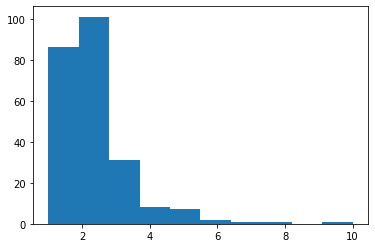

In [8]:
plt.hist(number_of_nodes[1:])

On garde que le premier composant connecté pour le moment.

In [9]:
sub_graph = sub_graphs[0]

In [10]:
def sample_non_edges(graph, n_sample):
    samples = []
    nodes = list(graph.nodes())
    edges = list(graph.edges())
    while len(samples) < n_sample:
        source, target = random.sample(nodes, 2)
        if (source, target) not in edges:
            samples.append((source, target))
    
    return samples

In [20]:
def take_sub_graph(graph, ratio):
    nodes = list(graph.nodes())
    np.random.shuffle(nodes)
    sub_graph = graph.subgraph(nodes[:int(len(nodes) * ratio)])
    sub_graphs = make_sub_graphs(sub_graph)
    sub_graphs = sorted(sub_graphs, key=lambda graph:graph.number_of_nodes(), reverse=True)
    return sub_graphs[0]

In [21]:
sub_graph = take_sub_graph(sub_graph, 0.4)

In [19]:
def generate_samples(graph, train_set_ratio):
    """
    Graph pre-processing step required to perform supervised link prediction
    Create training and test sets
    """
        
    # --- Step 0: The graph must be connected ---
    if nx.is_connected(graph) is not True:
        raise ValueError("The graph contains more than one connected component!")
       
    
    # --- Step 1: Generate positive edge samples for testing set ---
    residual_g = graph.copy()
    test_pos_samples = []
      
    # Shuffle the list of edges
    edges = list(residual_g.edges())
    np.random.shuffle(edges)
    
    # Define number of positive samples desired
    test_set_size = int((1.0 - train_set_ratio) * graph.number_of_edges())
    num_of_pos_test_samples = 0
    
    # Remove random edges from the graph, leaving it connected
    # Fill in the blanks

    i = 0
    with tqdm(total=test_set_size) as pbar:
        while len(test_pos_samples) < test_set_size:
            residual_g.remove_edge(edges[i][0], edges[i][1])
            if nx.is_connected(residual_g):
                test_pos_samples.append(edges[i])
                num_of_pos_test_samples += 1
                pbar.update(1)
            else:
                residual_g.add_edge(edges[i][0], edges[i][1])
            i += 1
    

    # Check if we have the desired number of positive samples for testing set 
    if num_of_pos_test_samples != test_set_size:
        raise ValueError("Enough positive edge samples could not be found!")

        
    # --- Step 2: Generate positive edge samples for training set ---
    # The remaining edges are simply considered for positive samples of the training set
    train_pos_samples = list(residual_g.edges())
        
        
    # --- Step 3: Generate the negative samples for testing and training sets ---
    # Fill in the blanks

    train_neg_samples = sample_non_edges(graph, len(train_pos_samples))
    test_neg_samples = sample_non_edges(graph, len(test_pos_samples))

    
    # --- Step 4: Combine sample lists and create corresponding labels ---
    # For training set
    train_samples = train_pos_samples + train_neg_samples
    train_labels = [1 for _ in train_pos_samples] + [0 for _ in train_neg_samples]
    # For testing set
    test_samples = test_pos_samples + test_neg_samples
    test_labels = [1 for _ in test_pos_samples] + [0 for _ in test_neg_samples]
    
    return residual_g, train_samples, train_labels, test_samples, test_labels

In [22]:
residual_g, train_samples, train_labels, test_samples, test_labels = generate_samples(graph=sub_graph, train_set_ratio=0.80)

100%|██████████| 10819/10819 [05:48<00:00, 31.05it/s]


In [25]:
import os
os.makedirs("./data")
nx.write_gml(residual_g, "./data/residual_graph.gml")

In [28]:
with open("./data/training_data.json", "w") as file:
    json.dump(
        {
            "train_samples": train_samples,
            "train_labels": train_labels,
            "test_samples": test_samples,
            "test_labels": test_labels
        }, file
    )

In [34]:
def feature_extractor(graph, deg_centrality, samples):
    """
    Creates a feature vector for each edge of the graph contained in samples 
    """
    feature_vector = [] 
    
    # --- Extract manually diverse features relative to each edge contained in samples --- 

    for edge in tqdm(samples):
        source_node, target_node = edge[0], edge[1]

        # Degree Centrality
        source_degree_centrality = deg_centrality[source_node]
        target_degree_centrality = deg_centrality[target_node]
        
        # Betweeness centrality  
        # diff_bt = betweeness_centrality[target_node] - betweeness_centrality[source_node]

        # Preferential Attachement 
        pref_attach = list(nx.preferential_attachment(graph, [(source_node, target_node)]))[0][2]

        # AdamicAdar
        aai = list(nx.adamic_adar_index(graph, [edge]))[0][-1]

        # Jaccard
        jacard_coeff = list(nx.jaccard_coefficient(graph, [edge]))[0][-1]
        
        # Create edge feature vector with all metric computed above
        feature_vector.append(np.array([source_degree_centrality, target_degree_centrality, 
                                        pref_attach, aai, jacard_coeff])) 
        
    return feature_vector

In [42]:
deg_centrality = nx.degree_centrality(graph)

In [43]:
train_features = feature_extractor(sub_graph, deg_centrality, train_samples)

100%|██████████| 86554/86554 [01:44<00:00, 827.47it/s] 


In [44]:
test_features = feature_extractor(sub_graph, deg_centrality, test_samples)

100%|██████████| 21638/21638 [00:25<00:00, 857.66it/s] 


In [47]:
def prediction(graph, train_features, test_features, train_labels, test_labels):
    """
    Downstream ML task using edge embeddings to classify them 
    """
    
    # --- Build the model and train it ---
    # Fill in the blanks
    
    lr = LogisticRegression()
    lr.fit(train_features, train_labels)
    
    train_preds = lr.predict_proba(train_features)[:, 1]
    test_preds = lr.predict_proba(test_features)[:, 1]
    
    print(test_preds)

    # --- Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from predictions ---
    # Fill in the blanks
    fpr, tpr, _ = roc_curve(test_labels, test_preds)
    roc_auc = roc_auc_score(test_labels, test_preds)
    
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return lr, roc_auc

[0.97362124 0.99999999 0.9999628  ... 0.13438416 0.13076422 0.13438421]


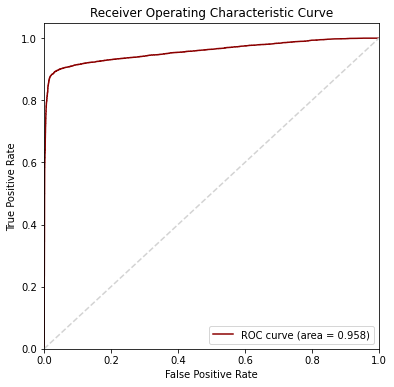

In [48]:
# --- Link prediction ---
lr, roc_auc = prediction(sub_graph, train_features, test_features, train_labels, test_labels)

In [49]:
lr.score(test_features, test_labels)

0.9290599870598022

In [51]:
from sklearn.metrics import f1_score

In [55]:
test_preds = lr.predict(test_features)

In [56]:
f1_score(test_labels, test_preds)

0.9251402097049501